In [20]:
#from zumi.zumi import Zumi
#from zumi.util.screen import Screen
import time
from datetime import datetime
#from zumi.util.vision import Vision
#from zumi.util.camera import Camera 
#from zumi.personality import Personality
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

#zumi =    Zumi()
#camera    = Camera()
#screen    = Screen()
#vision    = Vision()
#personality = Personality(zumi, screen)

In [ ]:
zumi.mpu.calibrate_MPU()

In [ ]:
log = {}

In [ ]:
def line_correction(bottom_left, bottom_right, desired_angle, threshold):
    if bottom_left > threshold and bottom_right < threshold:
        desired_angle +=5
    elif bottom_left < threshold and bottom_right > threshold:
        desired_angle -=5
    return desired_angle

def turning_correction(desired_angle, turn_angle):
    if desired_angle >= -turn_angle if desired_angle<0 else turn_angle:
        desired_angle = -abs(turn_angle-abs(desired_angle))
    else:
        desired_angle = abs(turn_angle-abs(desired_angle))
    return desired_angle

def turn_to_check(turn):
    zumi.reset_gyro()
    if turn == 'left':
        zumi.signal_left_on()
        zumi.turn_left(90)
        zumi.signal_left_off()
    elif turn == 'right':
        zumi.signal_right_on()
        zumi.turn_right(180)
        zumi.signal_right_off()
    time.sleep(0.01)
    desired_angle = zumi.read_z_angle()
    return desired_angle

def move_after_turning(speed, desired_angle):
    zumi.reset_gyro() 
    for x in range(3):
        zumi.go_straight(speed, desired_angle)

def object_detected(threshold=100):
    front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data() # Get center IR sensor value
    
    return front_right < threshold and front_left < threshold

def log_event(action):
    timestamp = datetime.now()
    log[action] = log.setdefault(action, [])
    log[action].append(timestamp)

def circle(turn, speed, number_of_objects, threshold):
    for j in range(number_of_objects):
        for i in range(4):
            zumi.reset_gyro()
            if turn == 'left':
                zumi.signal_left_on()
                zumi.turn_left(90)
                zumi.signal_left_off()
                log_event('move_left')
            elif turn == 'right':
                zumi.signal_right_on()
                zumi.turn_right(90)
                zumi.signal_right_off()
                log_event('move_right')
            desired_angle = zumi.read_z_angle()
            desired_angle = turning_correction(desired_angle, 90)
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.reset_gyro()
            while bottom_left > threshold or bottom_right > threshold:
                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
                desired_angle = line_correction(bottom_left, bottom_right, desired_angle, threshold)
                zumi.go_straight(speed, desired_angle)

def face_detection():
    camera.start_camera()
    captured_picture = camera.capture()
    captured_picture = vision.convert_to_gray(captured_picture) 
    camera.close()
    # screen.show_image(captured_picture) #used to check whether the picture of the face was in frame of the captured picture
    if vision.find_face(captured_picture)==None:
        screen.draw_text_center("No Face Detected!")
        screen.show_image(captured_picture)
        cv2.imwrite("Picture_Taken.png", captured_picture)
        np.save("Picture_Taken.npy",captured_picture)
        print("image1")
        camera.show_image(frame)
        return captured_picture
    else:
        screen.draw_text_center("Face Detected!")
        zumi.play_note(40, 500)
        return None   
    time.sleep(1)

                                        

def qr_code_command(message, speed, number_of_objects, threshold):
    if message == "Left Circle":
        circle('left', speed, number_of_objects, threshold)
    elif message == "Right Circle":
        circle('right', speed, number_of_objects, threshold)
    elif message == "Turn Left":
        zumi.signal_left_on()
        zumi.turn_left(90)
        zumi.signal_left_off()
    elif message == "Turn Right":
        zumi.signal_right_on()
        zumi.turn_right(90)
        zumi.signal_right_off()
    elif message == "Stop":
        zumi.stop()
    elif message == "Zumi is happy today!":
        personality.happy()
    elif message == "Zumi is angry today!":
        personality.angry()
    elif message == "Zumi is celebrating today!":
        personality.celebrate()
    elif message == "Take Picture_Picture_Taken!_Picture":
        time.sleep(1)
        image=face_detection()
        
    else:
        print("Invalid command")

def read_qr_code(speed, number_of_objects, threshold):
    camera.start_camera()
    frame = camera.capture()
    screen.show_image(frame) #to make sure qr-code is in frame of picture
    camera.close()
    qr_code = vision.find_QR_code(frame)
    message = vision.get_QR_message(qr_code)
    qr_code_command(message, speed, number_of_objects, threshold)
    return message


def line_correction(bottom_left, bottom_right, desired_angle, threshold):
    if bottom_left > threshold and bottom_right < threshold:
        desired_angle +=5
    elif bottom_left < threshold and bottom_right > threshold:
        desired_angle -=5
    return desired_angle

def turning_correction(desired_angle, turn_angle):
    if desired_angle >= -turn_angle if desired_angle<0 else turn_angle:
        desired_angle = -abs(turn_angle-abs(desired_angle))
    else:
        desired_angle = abs(turn_angle-abs(desired_angle))
    return desired_angle

def turn_to_check(turn):
    zumi.reset_gyro()
    if turn == 'left':
        zumi.signal_left_on()
        zumi.turn_left(90)
        zumi.signal_left_off()
    elif turn == 'right':
        zumi.signal_right_on()
        zumi.turn_right(180)
        zumi.signal_right_off()
    time.sleep(0.01)
    desired_angle = zumi.read_z_angle()
    return desired_angle

def move_after_turning(speed, desired_angle):
    zumi.reset_gyro() 
    for x in range(3):
        zumi.go_straight(speed, desired_angle)

def finish_with_180_turn():
    zumi.stop()
    log_event("finish")
    print("Reached end. Performing 180° turn.")
    screen.draw_text_center("Finisher box\nTurning 180°")
    zumi.turn_left(180)
    screen.draw_text_center("Done!")

def save_dict_to_csv(data_dict):
    # Generate file name with current time
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_name = "Zumi7337_output_" + current_time + ".csv"

    # Create empty list to store rows
    rows = []

    # Go through all actions and timestamps
    for action, timestamps in data_dict.items():
        for timestamp in timestamps:
            # Add row to list of rows
            rows.append({"timestamp": timestamp, "action": action})

    # Create DataFrame from list of rows
    df = pd.DataFrame(rows)

    # Sort DataFrame by column timestamp
    df = df.sort_values(by='timestamp')

    # Save DataFrame in CSV file
    df.to_csv(file_name, index=False)
    print("Data saved in ", file_name)

In [ ]:
def read_qr_code(speed, number_of_objects, threshold):
    camera.start_camera()
    frame = camera.capture()
    camera.close()
    camera.show_image(frame)
    qr_code = vision.find_QR_code(frame)
    message = vision.get_QR_message(qr_code)
    qr_code_command(message, speed, number_of_objects, threshold)
    return message

print(read_qr_code(5, 1, 100))

In [21]:
#testing csv file
df = pd.read_csv(r'C:\Source\Python\robot_challenge\submissions\03.06.2025\Zumi7337_output_20250603_094833.csv', delimiter=',') 

print(df)

                                              action  \
0                                              start   
1                                           end_line   
2                                           end_line   
3                                         check_left   
4                                        check_right   
5                                         move_right   
6                                    object_detected   
7                                     object_removed   
8                         loking for qr_code of face   
9                                      face_detected   
10                                   object_detected   
11                                    object_removed   
12                        loking for qr_code of face   
13                                          end_line   
14                                        check_left   
15                                       check_right   
16                                        move_r

In [28]:
def manhattan_distance_with_heading(df):
    grid = np.zeros((600, 600), dtype=int)
    x, y = 300, 300
    grid[y, x] = 1

    # Initial heading: facing West
    heading_order = ['N', 'E', 'S', 'W']  # clockwise
    heading_index = 3  # index for 'W'

    movement_starts = ['start', 'restart_moving', 'end_line']
    stop_actions = ['stop', 'face_detected', 'qr_code', 'object_detected', 'finish', 'finish_with_180_turn']

    # Helper to rotate heading
    def rotate_heading(current_index, turn):
        if turn == 'move_right':  # clockwise
            return (current_index + 1) % 4
        elif turn == 'move_left':  # counterclockwise
            return (current_index - 1) % 4
        return current_index

    i = 0
    while i < len(df) - 1:
        action = df.loc[i, 'action']

        if action in ['move_left', 'move_right']:
            heading_index = rotate_heading(heading_index, action)

        elif action in movement_starts:
            start_time = pd.to_datetime(df.loc[i, 'timestamp'])

            for j in range(i + 1, len(df)):
                next_action = df.loc[j, 'action']

                if next_action == 'end_line':
                    if j + 1 < len(df) and df.loc[j + 1, 'action'] == 'end_line':
                        continue  # skip duplicates

                    end_time = pd.to_datetime(df.loc[j, 'timestamp'])
                    duration = max(1, math.ceil((end_time - start_time).total_seconds()))

                    # Move according to current heading
                    heading = heading_order[heading_index]
                    for _ in range(duration):
                        if heading == 'N':
                            y -= 1
                        elif heading == 'S':
                            y += 1
                        elif heading == 'E':
                            x += 1
                        elif heading == 'W':
                            x -= 1

                        if 0 <= x < 600 and 0 <= y < 600:
                            grid[y, x] = 1
                        else:
                            print(f"Out of bounds at ({x}, {y})")

                    i = j  # jump to this 'end_line'
                    break

                elif next_action in stop_actions:
                    i = j
                    break

        i += 1


    return grid

Estimated Manhattan distance: 22 units


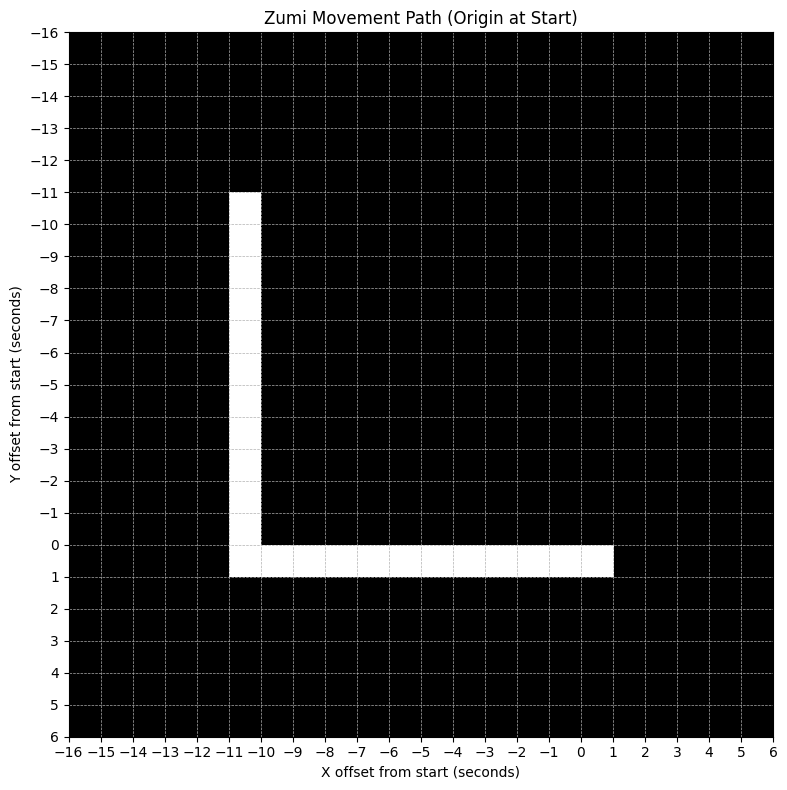

In [29]:
def plot_path(grid):
    y_coords, x_coords = np.nonzero(grid)

    if len(x_coords) == 0 or len(y_coords) == 0:
        print("No movement found to plot.")
        return

    margin = 5
    xmin, xmax = max(0, x_coords.min() - margin), min(600, x_coords.max() + margin + 1)
    ymin, ymax = max(0, y_coords.min() - margin), min(600, y_coords.max() + margin + 1)

    # Crop the grid
    cropped = grid[ymin:ymax, xmin:xmax]

    # Shift coordinates so (300, 300) becomes (0, 0)
    x_shift = 300
    y_shift = 300
    xmin_shifted = xmin - x_shift
    xmax_shifted = xmax - x_shift
    ymin_shifted = ymin - y_shift
    ymax_shifted = ymax - y_shift

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(
        cropped,
        cmap='gray',
        origin='upper',
        extent=[xmin_shifted, xmax_shifted, ymax_shifted, ymin_shifted]  # flipped y for origin='upper'
    )
    plt.title("Zumi Movement Path (Origin at Start)")
    plt.xlabel('X offset from start (seconds)')
    plt.ylabel('Y offset from start (seconds)')
    plt.gca().set_aspect('equal')

    # Ticks every 1
    plt.xticks(np.arange(xmin_shifted, xmax_shifted + 1, 1))
    plt.yticks(np.arange(ymin_shifted, ymax_shifted + 1, 1))

    plt.grid(True, linewidth=0.5, linestyle='--')
    plt.tight_layout()
    plt.show()

grid = manhattan_distance(df)
plot_path(grid)

In [ ]:
log = {}
zumi.reset_gyro()
desired_angle = zumi.read_z_angle() 
number_of_objects = 0

log_event('start')
log_event('end_line')

try:
    while True:
        # Set the threshold for the IR sensors and the speed
        threshold = 50 
        speed = 5

        if object_detected():
            zumi.stop()
            zumi.brake_lights_on()
            time.sleep(2)
            zumi.brake_lights_off()
            log_event('object_detected')
            number_of_objects += 1
            zumi.play_note(1, 500) # 1 is note type (1 - 60), 500 is duration in ms
            screen.draw_text_center("Objects: " + str(number_of_objects)) # Display object count on screen
            # Wait until the object is removed
            print("Waiting for object to be removed...")
            while object_detected():
                zumi.stop()
                time.sleep(0.1)
            log_event('object_removed')
            print("Object removed. Resuming movement.")
            log_event('qr_code_read')
            message = read_qr_code(speed, number_of_objects, threshold)
            log_event('qr_code_command: ' + str(message) + " done")
            

        # Read all IR sensor values
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()

        # Correction to line if one sensor is on the line and the other is off
        desired_angle = line_correction(bottom_left, bottom_right, desired_angle, threshold)

        # Move forward with the corrected heading
        if bottom_left > threshold or bottom_right > threshold:
            zumi.go_straight(speed, desired_angle)
        else:
            log_event('end_line')
            
            if (log['end_line'][-1] - log['end_line'][-2]).total_seconds() > 3:
                go_left = True
            
                log_event('check_left')
                # Turn to check if left is line
                turned_left_angle = turn_to_check('left')

                # Calculate angle if turn was too much or not enough
                desired_angle = turning_correction(turned_left_angle, 90)

                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            else:
                go_left = False
            if (bottom_left > threshold or bottom_right > threshold) and go_left:
                log_event('move_left')
                move_after_turning(speed, desired_angle)
            else:
                
                log_event('check_right')
                # Turn to check if right is line
                turned_right_angle = turn_to_check('right') 
                
                # Calculate angle if turn was too much or not enough
                desired_angle = turning_correction(turned_right_angle, 180)

                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()

                if bottom_left > threshold or bottom_right > threshold:
                    log_event('move_right')
                    move_after_turning(speed, desired_angle)
                else:
                    zumi.stop()
                    log_event('stop')
                    finish_with_180_turn()
                    log_event('finish_with_180_turn')
                    break
finally:
    zumi.stop()
    log_event('stop')
    #save_dict_to_csv(log)